<a href="https://colab.research.google.com/github/bessszilard/Udacity-Self-Driving-Car-Engineer-Nanodegree-Program/blob/Pr4_YUV_img/Project-4-Behavioral-Cloning/Behavioral_cloning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !rm Self-Driving-Car-Simulator-Data -r
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

fatal: destination path 'Self-Driving-Car-Simulator-Data' already exists and is not an empty directory.


In [3]:
!ls
!ls Self-Driving-Car-Simulator-Data

acc_training_curve.png	Self-Driving-Car-Simulator-Data  training_curve.png
sample_data		steering_distribution.png
driving_log.csv  IMG  LICENSE  README.md


In [4]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

In [6]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

def path_to_image(dir, line):
    filename = source_path.split('\\')[-1] 
    current_path = dir + filename
    return cv2.imread(current_path)

for line in lines:
    steering_center = float(line[3])
    
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    
    image = cv2.imread(current_path)
    
    dir = 'Self-Driving-Car-Simulator-Data/IMG/'
    image_center = path_to_image(dir, line[0])
    
    images.append(image_center)
    measurement = float(line[3])
    measurements.append(measurement)

print(len(images))

10209


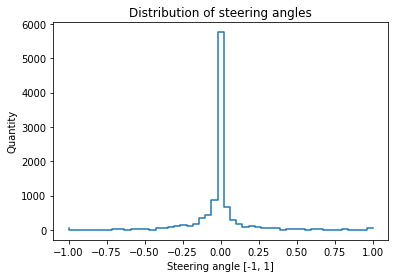

In [7]:
# Or, if bin is an integer, you can set the number of bins:
bins = 50
hist, bin_edges = np.histogram(measurements, bins=bins)
x = np.linspace(-1, 1, bins)
# print(x)
# print(hist)
# plt.plot(x, hist)
# plt.show()
# plt.plot(measurements)
plt.step(x, hist)
plt.title("Distribution of steering angles")
plt.xlabel("Steering angle [-1, 1]")
plt.ylabel("Quantity")

plt.savefig('steering_distribution.png', dpi=300)
files.download('steering_distribution.png')

In [0]:
def img_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Nvidia model needed this color space
    img = cv2.GaussianBlur(img, (3, 3), 0)     # Gaussian blur removes noise
    return img

0.0
(160, 320, 3)


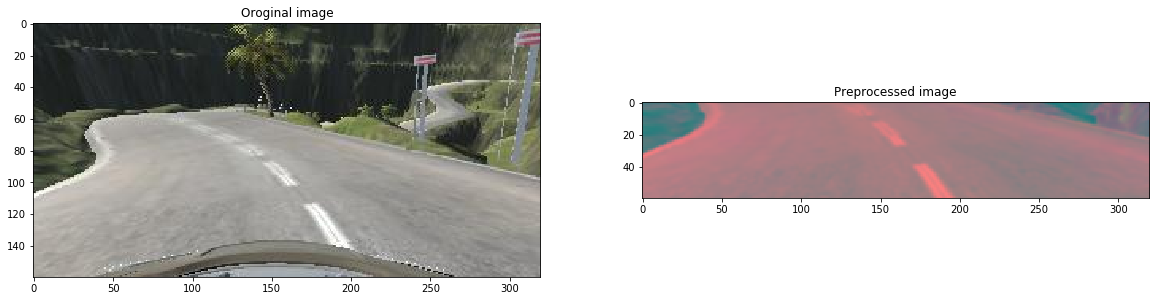

In [9]:
index = random.randint(0, len(measurements)-1)
# plt.imshow(images[index])
print(measurements[index])
img_rgb = cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img_rgb)
ax[0].set_title("Oroginal image")
proc_img = img_preprocess(images[index])
cropped_img = proc_img[75:-25,:,:]
ax[1].imshow(cropped_img)
ax[1].set_title("Preprocessed image")
print(images[index].shape)

In [10]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                filename = batch_sample[0].split('\\')[-1]
                current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
                center_image = cv2.imread(current_path)
                center_angle = float(batch_sample[3])
                
                center_image = img_preprocess(center_image)
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

train_generator_data = generator(train_samples, batch_size=batch_size)
print(np.array(train_generator_data))

print("Training set ", len(train_samples))
print(len(validation_samples))

<generator object generator at 0x7fb8dff49570>
Training set  8167
2042


In [11]:
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70, 25),(0, 0))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

optimizer = Adam(lr = 0.3e-3)
model.compile(loss='mse', optimizer=optimizer)
history_object = model.fit_generator(train_generator,
                                    steps_per_epoch=np.ceil(len(train_samples)/batch_size),
                                    validation_data=validation_generator,
                                    validation_steps=np.ceil(len(validation_samples)/batch_size),
                                    epochs=10, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
256/256 [==============================] - 23s 92ms/step - loss: 0.0323 - val_loss: 0.0264
Epoch 2/10
256/256 [==============================] - 20s 78ms/step - loss: 0.0267 - val_loss: 0.0216
Epoch 3/10
256/256 [==============================] - 20s 78ms/step - loss: 0.0244 - val_loss: 0.0233
Epoch 4/10
256/256 [==============================] - 20s 80ms/step - loss: 0.0227 - val_loss: 0.0183
Epoch 5/10
256/256 [==============================] - 21s 81ms/step - loss: 0.0218 - val_loss: 0.0176
Epoch 6/10
256/256 [==============================] - 21s 81ms/step - loss: 0.0216 - val_loss: 0.0213
Epoch 7/10
256/256 [==============================] - 21s 81ms/step - loss: 0.0205 - val_loss: 0.0154
Epoch 8/10
256/256 [==============================]

dict_keys(['val_loss', 'loss'])


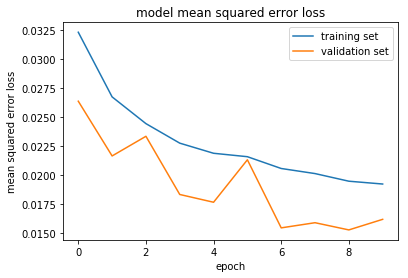

KeyError: ignored

In [12]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_curve.png', dpi=300)
files.download('training_curve.png')
plt.show()

In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')

In [14]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes='True')
# model_pic = plt.imread('model.png')
# plt.imshow(model_pic)

# files.download('model.png')
# print(model.summary())

FileNotFoundError: ignored

In [29]:
# source: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

from keras import models

layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

index = 100 # random.randint(0, len(measurements)-1)
print(measurements[index])
img_rgb = cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB)
image_array = np.asarray(images[index])
image_array = img_preprocess(image_array)
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))

-0.4


12
(1, 160, 320, 3)


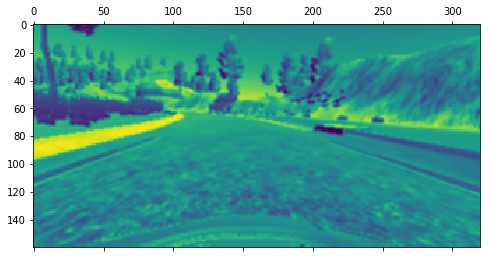

(1, 65, 320, 3)


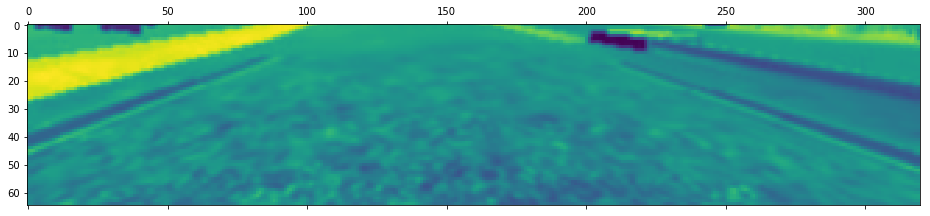

(1, 31, 158, 24)


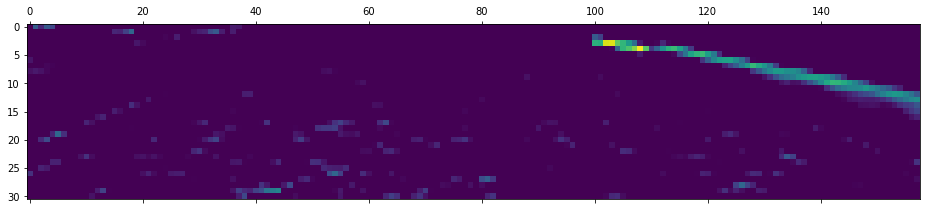

(1, 14, 77, 36)


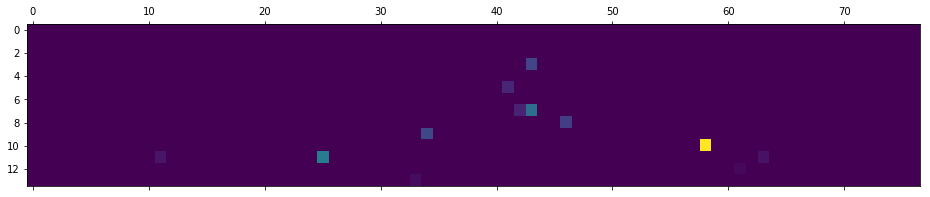

(1, 5, 37, 48)


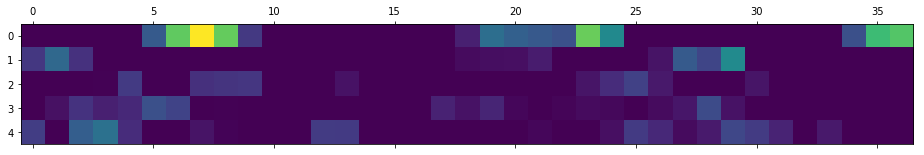

(1, 3, 35, 64)


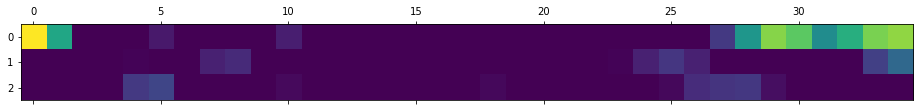

(1, 1, 33, 64)


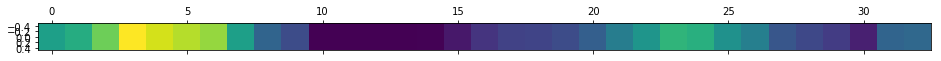

In [30]:
activations = activation_model.predict(image_array[None, :, :, :], batch_size=1) # Returns a list of five Numpy arrays: one array per layer activation
print(len(activations))
for i in range(7):
    first_layer_activation = activations[i]
    print(first_layer_activation.shape)
    plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
    plt.show()